# Hubble Source Catalog API Notebook: SMC Color-Magnitude Diagram

A [new MAST interface][1] supports queries to the current and previous versions of the [Hubble Source Catalog][2]. It allows searches of the summary table (with multi-filter mean photometry) and the detailed table (with all the multi-epoch measurements).  It also has an associated [API][3], which is used in this notebook.

This is based on part of [HSC Use Case #2][4].
* It searches the HSC for point-like objects in the Small Magellanic Cloud (SMC) with ACS/WFC V and I band measurements,
* selects a subset of those objects in a V-I color range,
* plots the positions of the objects on the sky, and
* plots the color-magnitude diagram for the selected objects.

The whole process takes only about 2 minutes to complete.

Another [notebook][5] demonstrates other search capabilities of the API to find variable objects and plot their light curves. A more complex notebook that shows how to access the proper motion tables using the HSC API is also [available][6].

  [1]: https://catalogs.mast.stsci.edu/hsc
  [2]: https://archive.stsci.edu/hst/hsc
  [3]: https://catalogs.mast.stsci.edu/docs/hsc.html
  [4]: https://archive.stsci.edu/hst/hsc/help/use_case_2_v3.html
  [5]: ../HSCV3_API/hscv3_api.ipynb
  [6]: ../SWEEPS_HSCV3P1_API/sweeps_hscv3p1_api.ipynb

# Instructions: 
* Complete the initialization steps [described below](#Initialization).
* Run the notebook.

Running the notebook from top to bottom takes about 2 minutes.

# Table of Contents
* [Initialization](#Initialization)
* [Find variable objects the SMC](#smc)
    * [Use MAST name resolver](#resolver)
    * [Search HSC summary table](#summary)
    * [Show object positions on the sky](#positions)
    * [Plot the color-magnitude diagram](#cmd)

# Initialization <a class="anchor" id="Initialization"></a>

### Install Python modules

1. _This notebook requires the use of **Python 3**._
1. Modules can be installed with `conda`, if using the [Anaconda distribution][1] of python, or with `pip`.
   - If you are using `conda`, do not install / update / remove a module with `pip`, that exists in a `conda` [channel][2].
   - If a module is not available with `conda`, then it's okay to install it with `pip`


  [1]: https://www.anaconda.com/products/distribution
  [2]: https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/channels.html

In [1]:
import astropy
from astropy.coordinates import SkyCoord
import time
import sys
import os
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from astropy.table import Table
import pandas as pd

from io import StringIO

from fastkde import fastKDE
from scipy.interpolate import RegularGridInterpolator
from astropy.modeling import models, fitting

# set width for pprint
astropy.conf.max_width = 150

In [2]:
# set universal matplotlib parameters
plt.rcParams.update({'font.size': 16})

## Useful functions

- Execute HSC searches and resolve names using [MAST query][1].
- Here we define several interrelated functions for retrieving information from the MAST API.
  - The `hcvcone(ra, dec, radius [, keywords])` function searches the HCV catalog near a position.
  - The `hcvsearch()` function performs general non-positional queries.
  - The `hcvmetadata()` function gives information about the columns available in a table. 

  
  [1]: https://mast.stsci.edu/api/v0/MastApiTutorial.html

In [3]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"


def hsccone(ra, dec, radius, table="summary", release="v3", format="csv", magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a cone search of the HSC catalog

    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json, table
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """

    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hscsearch(table=table, release=release, format=format, magtype=magtype,
                     columns=columns, baseurl=baseurl, verbose=verbose, **data)


def hscsearch(table="summary", release="v3", magtype="magaper2", format="csv",
              columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)

    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json, table
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """

    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv", "votable", "json", 'table'):
        raise ValueError("Bad value for format")
    if format == "table":
        rformat = "csv"
    else:
        rformat = format
    url = f"{cat2url(table, release, magtype, baseurl=baseurl)}.{rformat}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hscmetadata(table, release, magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError(f"Some columns not found in table: {', '.join(badcols)}")
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = f"[{','.join(columns)}]"

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    elif format == "table":
        # use pandas to work around bug in Windows for ascii.read
        return Table.from_pandas(pd.read_csv(StringIO(r.text)))
    else:
        return r.text


def hscmetadata(table="summary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = f"{cat2url(table, release, magtype, baseurl=baseurl)}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'], x['type'], x['description']) for x in v],
                names=('name', 'type', 'description'))
    return tab


def cat2url(table="summary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table, release, magtype)
    if table == "summary":
        url = f"{baseurl}/{release}/{table}/{magtype}"
    else:
        url = f"{baseurl}/{release}/{table}"
    return url


def checklegal(table, release, magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError(f"Bad value for release (must be one of {', '.join(releaselist)})")
    if release == "v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions")
    if table not in tablelist:
        raise ValueError(f"Bad value for table (for {release} must be one of {', '.join(tablelist)})")
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError(f"Bad value for magtype (must be one of {', '.join(magtypelist)})")

### Helper function for crowded scatterplots

`select_subset()` selects a sample of points in crowded regions to speed up plotting. This converts the fastkde PDF values (which are probabilities per unit area using the x and y data units) to the expected number of points within a region covered by the marker on the plot.  It then picks only a few points to plot in crowded regions while selecting all the points in uncrowded regions.

Inputs: 
* `zs` = array of PDF density values computed using fastkde
* `axes` = axis range tuple from fastkde
* `markersize` = matplotlib marker size (which is an area in points)
* `over` = oversampling factor (empirically 5 fills in the holes)
* `verbose` = print additional info

Returns an array of subscripts to plot from `zs`.

In [4]:
def select_subset(zs, kde_axes, fig, markersize=2, over=5, verbose=False):
    """
    Select a subset of points in crowded regions to speed up plotting
    Returns array of subscripts to plot from zs    
    """
    # get figure size in points
    figsize = fig.get_size_inches()*72.0
    # scale factor to convert PDF values to expected number of points in the marker area
    # divide ranges by 2 because fastkde pads the data ranges to allow FFTs
    range0 = 0.5*(kde_axes[0][-1]-kde_axes[0][0])
    range1 = 0.5*(kde_axes[1][-1]-kde_axes[1][0])
    ss = len(zs) * range0 * range1 * markersize / (over*figsize[0]*figsize[1])
    cc = (1.0/(ss*zs).clip(min=1)).cumsum()
    wsel = np.searchsorted(cc, np.arange(np.ceil(cc[-1]).astype(int)+1),
                           side='right').clip(max=len(zs)-1)
    if verbose:
        print(f"Plotting {len(wsel)} of {len(zs)} points")
    return wsel

## Find objects in the SMC <a name="smc"></a>

This is based on [HSC Use Case #2](https://archive.stsci.edu/hst/hsc/help/use_case_2_v3.html), which includes an example of creating a color-magnitude diagram for the SMC using <a href="https://mastweb.stsci.edu/hcasjobs">MAST CasJobs</a>.  This is simple to do using the HSC API.

### Use `astropy` name resolver to get position of the SMC <a name="resolver"></a>

In [5]:
target = 'SMC'
coord_smc = SkyCoord.from_name(target)

ra_smc = coord_smc.ra.degree
dec_smc = coord_smc.dec.degree
print(f'ra: {ra_smc}\ndec: {dec_smc}')

ra: 13.15833
dec: -72.80028


### Select objects with the desired magnitudes and colors near the SMC <a name="summary"></a>

This searches the summary table for objects in a 3x3 degree box centered on the galaxy that has measurements in both ACS F555W and F814W.  It computes the V-I color, and selects only objects in the range $-1.5 < V-I < 1.5$.

This large query returns more than 700,000 objects, and **takes about a minute to complete**.

In [6]:
# save typing a quoted list of columns
columns = """MatchID,MatchRA,MatchDec,CI,A_F555W,A_F814W""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

# select objects with at least one ACS F555W and ACS F814W measurement
# and with concentration index 0.9 < CI < 1.6, consistent with point sources
# search a large 3x3 degree box in RA and Dec centered on the SMC
ddec = 1.5
dra = ddec/np.cos(np.radians(dec_smc))
constraints = {'A_F555W_N.gte': 1, 'A_F814W_N.gte': 1, 'CI.gt': 0.9, 'CI.lt': 1.6,
               'MatchDec.gt': dec_smc-ddec, 'MatchDec.lt': dec_smc+ddec,
               'MatchRA.gt': ra_smc-dra, 'MatchRA.lt': ra_smc+dra}

# do a search with a large number of rows allowed
t0 = time.time()
tab = hscsearch(table="summary", release='v3', columns=columns, verbose=True, pagesize=1000000, format='table', **constraints)

print("{:.1f} s: retrieved data and converted to {}-row astropy table".format(time.time()-t0, len(tab)))

# compute color column and select for objects in more limited color range
tab['V-I'] = tab['A_F555W'] - tab['A_F814W']
tab = tab[(tab['V-I'] < 1.5) & (tab['V-I'] > -1.5)]
print(f"{(time.time()-t0):.1f} s: selected {len(tab)} objects with -1.5 < V-I < 1.5")

# clean up the output format
tab['A_F555W'].format = "{:.3f}"
tab['A_F814W'].format = "{:.3f}"
tab['V-I'].format = "{:.3f}"
tab['CI'].format = "{:.3f}"
tab['MatchRA'].format = "{:.6f}"
tab['MatchDec'].format = "{:.6f}"
tab

https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/summary/magaper2.csv?pagesize=1000000&A_F555W_N.gte=1&A_F814W_N.gte=1&CI.gt=0.9&CI.lt=1.6&MatchDec.gt=-74.30028&MatchDec.lt=-71.30028&MatchRA.gt=8.085679185085809&MatchRA.lt=18.23098081491419&columns=%5BMatchID%2CMatchRA%2CMatchDec%2CCI%2CA_F555W%2CA_F814W%5D
14.2 s: retrieved data and converted to 764094-row astropy table
14.2 s: selected 761835 objects with -1.5 < V-I < 1.5


MatchID,MatchRA,MatchDec,CI,A_F555W,A_F814W,V-I
int64,float64,float64,float64,float64,float64,float64
84813765,14.755829,-72.143661,1.211,24.268,23.946,0.322
84756978,15.963504,-72.820415,1.102,26.589,26.074,0.515
58851028,12.947027,-72.979664,1.160,24.201,23.871,0.330
58782821,12.928665,-72.963395,1.148,24.908,24.598,0.310
58742759,17.107705,-72.865522,0.910,25.122,24.766,0.357
58634338,14.844671,-72.168256,0.950,23.960,23.750,0.210
58598705,17.009451,-72.883678,0.933,21.463,21.469,-0.006
58598720,12.776284,-73.180862,1.038,24.514,24.225,0.289
58598733,14.707026,-72.344124,0.971,24.572,24.312,0.260


### Plot object positions on the sky <a name="positions"></a>

We mark the galaxy center as well.  These fields are sprinkled all over the galaxy (as determined by the HST proposals).

Note there are 761835 observations in `tab`. Each observation is plotted as a small point (`.`), so the fields in the plot represent thousands of observations.

In [7]:
# convert to pandas for easier manipulation
obs = tab[['MatchRA', 'MatchDec']].to_pandas()

# round
obs.MatchRA = obs.MatchRA.round(0)
obs.MatchDec = obs.MatchDec.round(2)

# get the value counts, to "roughly" demonstrate the observations per plotted square cluster
obs.value_counts()

MatchRA  MatchDec
13.0     -73.10      14552
         -73.09      13337
15.0     -72.16      11778
         -72.15      11527
13.0     -73.11      11149
                     ...  
12.0     -72.56          9
13.0     -73.03          9
15.0     -73.22          7
14.0     -72.53          6
12.0     -72.54          2
Name: count, Length: 214, dtype: int64

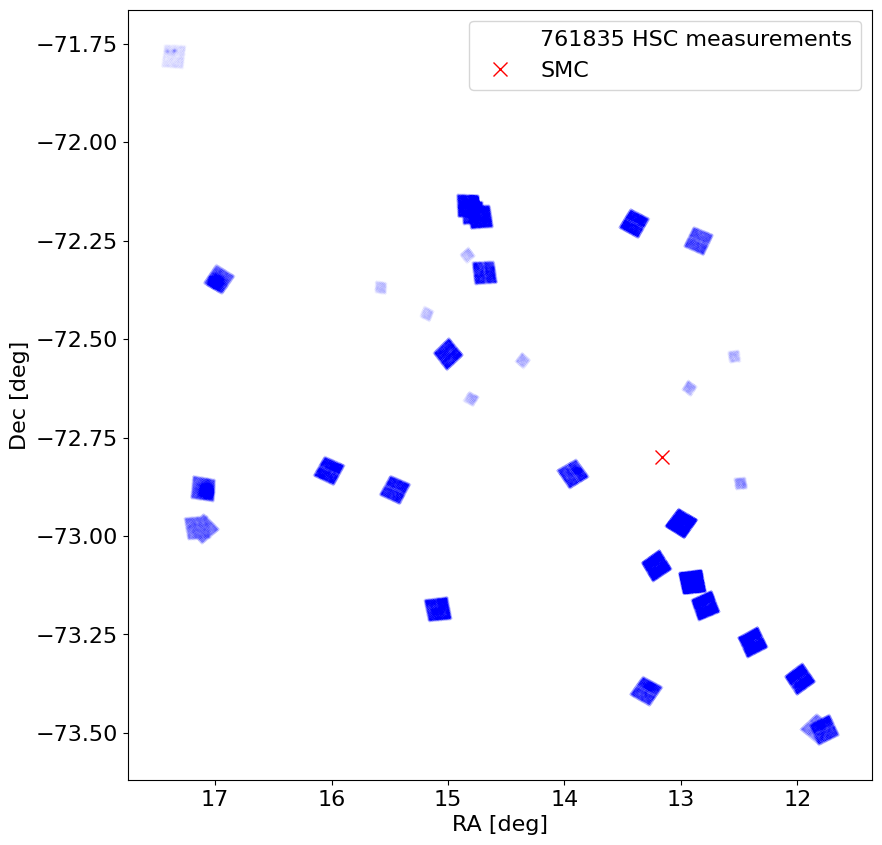

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
# adjust markersize (0-1) and alpha (0-1) as desired
ax.plot('MatchRA', 'MatchDec', 'bo', markersize=0.005, alpha=0.4, data=tab, label=f'{len(tab)} HSC measurements')
ax.plot(ra_smc, dec_smc, 'rx', label=target, markersize=10)
ax.invert_xaxis()
ax.set_aspect(1.0/np.cos(np.radians(dec_smc)))
ax.set(xlabel='RA [deg]', ylabel='Dec [deg]')
ax.legend()

### Plot the color-magnitude diagram <a name="cmd"></a>

This uses the `fastkde` module to get a kernel density estimate in order to plot a dense scatterplot.

In [9]:
# Calculate the point density
t0 = time.time()
x = tab['V-I']
y = tab['A_F555W']
myPDF, axes = fastKDE.pdf(x, y, numPoints=2**9+1)
print(f"kde took {(time.time()-t0):.1f} sec for {len(x)} points")

# interpolate to get z values at points
finterp = RegularGridInterpolator((axes[1], axes[0]), myPDF, bounds_error=False, fill_value=0.0)
z = finterp((y, x))

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

kde took 3.3 sec for 761835 points


Plotting 208665 of 761835 points


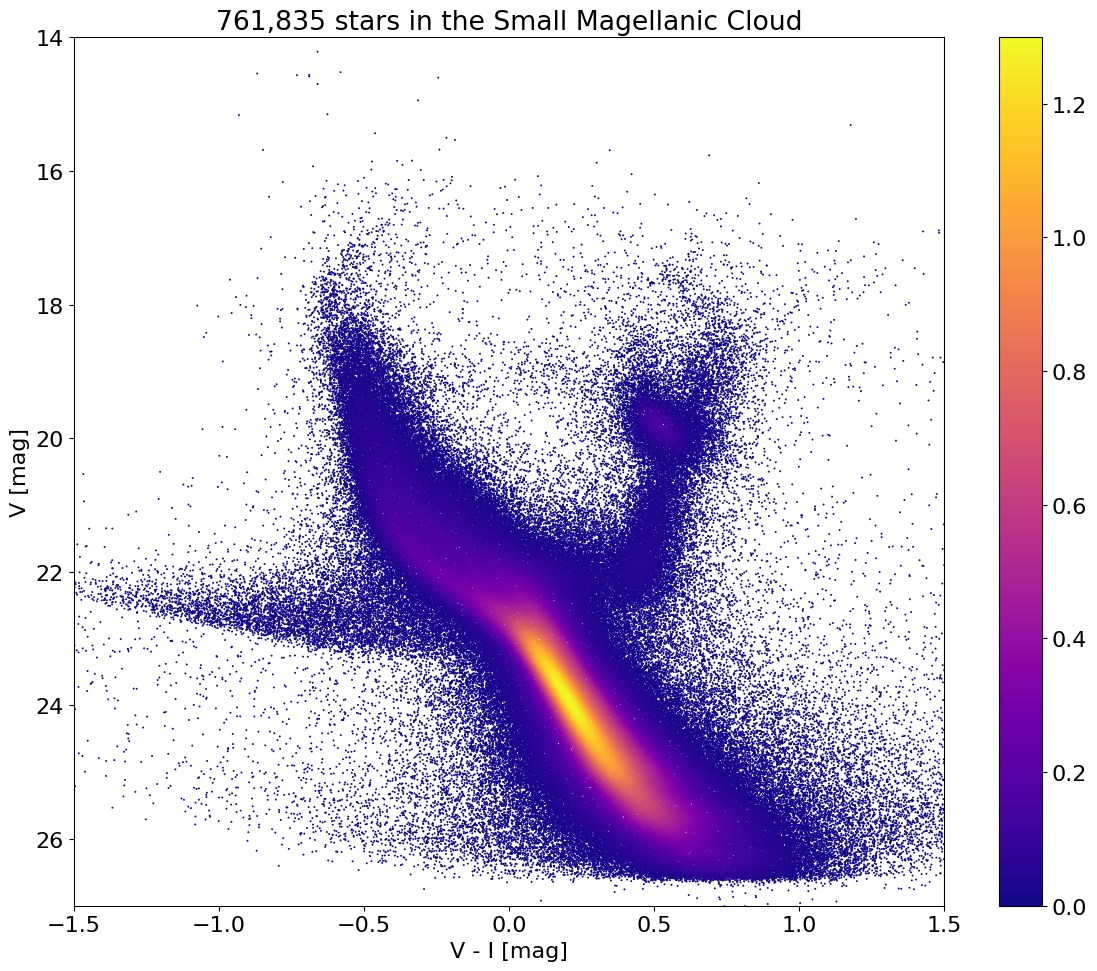

In [10]:
fig, ax = plt.subplots(figsize=(12, 10), tight_layout=True)

# select a subset of points to plot
wsel = select_subset(zs, axes, fig, verbose=True)

sc = ax.scatter(xs[wsel], ys[wsel], c=zs[wsel], s=2, edgecolors='none', cmap='plasma')
ax.set(xlabel='V - I [mag]', ylabel='V [mag]',
       title=f'{len(tab):,} stars in the Small Magellanic Cloud',
       xlim=(-1.5, 1.5), ylim=(14, 27))
ax.invert_yaxis()
_ = fig.colorbar(sc, ax=ax)

## About this Notebook
If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at `archive@stsci.edu`.

**Author(s):** Rick White, Trenton McKinney <br>
**Last Updated:** May 2023 <br>
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 